In [1]:
import os
import numpy as np 
import pandas as pd
import arviz as az
import pymc3 as pm
import spc_os
import pickle
import seaborn as sns
import cellbell
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.visualization.handle_data import combine_posterior_variables
RANDOM_SEED = 281090

In [2]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'
models_dir = '../models/bayesian/'
reports_dir = '../reports/'

In [3]:
%mkdir ../reports/for_print

mkdir: cannot create directory ‘../reports/for_print’: File exists


In [4]:
with open('../data/aa_resid_dic.pkl', 'rb') as my_file:
    aa_dic = pickle.load(my_file)

In [5]:
from spc_imports import *
set_up_plt()

/home/sperez/bin/PYTHON_SCRIPTS/spc_imports.py:21: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams["text.latex.preamble"] = [


# Load MD data

In [6]:
method = 'ppm' # sparta_plus or ppm
nucleus = 'CA' # CA C CB N
data_size = 1000  # 70000 max data_size
model_name = 'skew_model'
infer = False

In [34]:
def load_data_frames(processed_data_dir, method, nucleus, data_size, model_name, RANDOM_SEED):
    df_diff = pd.read_pickle(processed_data_dir + 'diff_CS.pkl')
    mask = df_diff.dropna(axis=1).columns
    df_diff = df_diff.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
    df_exp_o = pd.read_pickle(processed_data_dir + 'open_CS.pkl')

    df_exp_o = df_exp_o.loc[:, mask].xs(nucleus, level='nuclei', axis=1)

    df_3fb5 = pd.read_pickle(processed_data_dir +
                             f'3FB5_lb/CS_{method}_3FB5_lb.pkl')

    df_3fb5 = df_3fb5.loc[:, mask].sample(data_size,
                                          random_state=RANDOM_SEED)
    df_3fb5 = df_3fb5.xs(nucleus, level='nuclei', axis=1)

    df_5vk6 = pd.read_pickle(processed_data_dir +
                             f'5VK6_lb/CS_{method}_5VK6_lb.pkl')

    df_5vk6 = df_5vk6.loc[:, mask].sample(data_size,
                                          random_state=RANDOM_SEED)
    df_5vk6 = df_5vk6.xs(nucleus, level='nuclei', axis=1)

    df_5vkh = pd.read_pickle(processed_data_dir +
                             f'5VKH_lb/CS_{method}_5VKH_lb.pkl')

    df_5vkh = df_5vkh.loc[:, mask].sample(data_size,
                                          random_state=RANDOM_SEED)
    df_5vkh = df_5vkh.xs(nucleus, level='nuclei', axis=1)
    return df_exp_o,df_3fb5, df_5vk6, df_5vkh,mask

In [36]:
df_exp_o, df_3fb5, df_5vk6, df_5vkh, mask = load_data_frames(processed_data_dir, method, nucleus, data_size, model_name, RANDOM_SEED)

## Make histograms

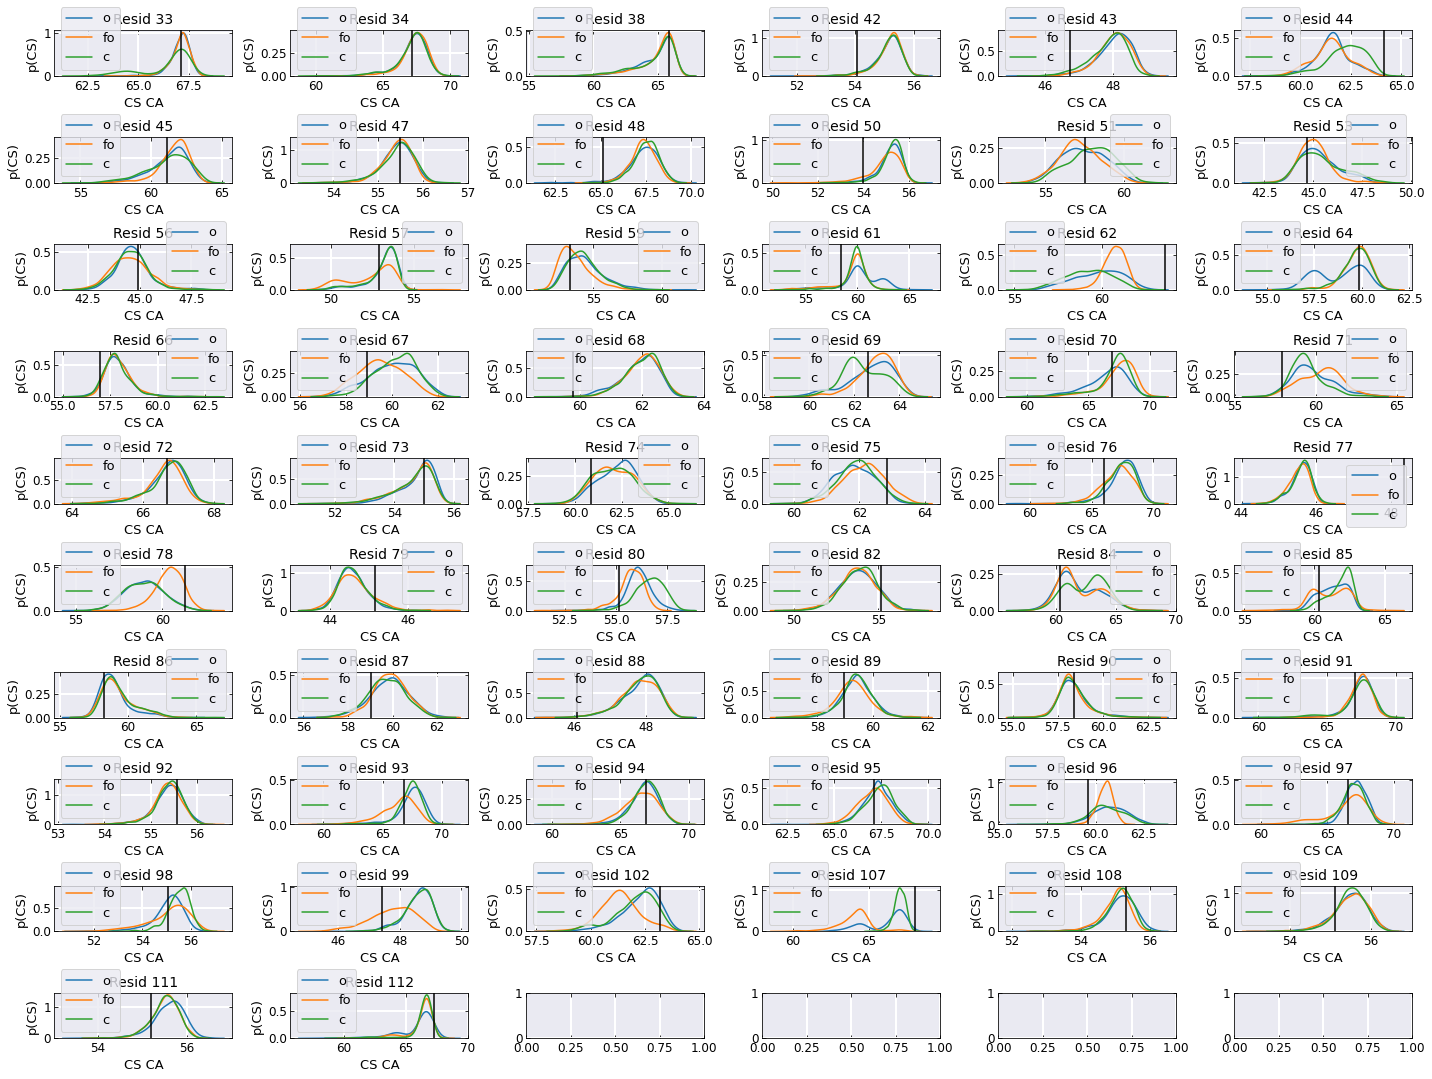

In [9]:
fig, ax = plt.subplots(df_3fb5.shape[1] // 6 + 1, 6, figsize=(20, 15))
ax = ax.flatten()
for i, resid in enumerate(df_3fb5):
    sns.kdeplot(df_3fb5[resid], ax=ax[i], label='o')
    sns.kdeplot(df_5vk6[resid], ax=ax[i], label='fo')
    sns.kdeplot(df_5vkh[resid], ax=ax[i], label='c')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_xlabel(f'CS {nucleus}')
    ax[i].set_ylabel('p(CS)')
    ax[i].axvline(x=df_exp_o[resid][0], c="black")
    ax[i].legend()
fig.tight_layout()
fig.savefig(reports_dir + f'for_print/hist_{method}_{nucleus}.png')

In [10]:
aa_selected = [102]

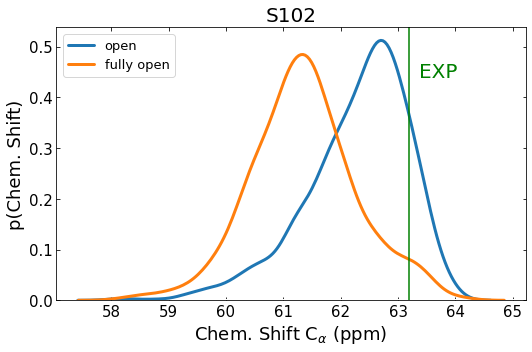

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.))
resid = aa_selected[0]
sns.kdeplot(df_3fb5[resid], ax=ax, label='open', lw=3)
sns.kdeplot(df_5vk6[resid], ax=ax, label='fully open', lw=3)
#sns.kdeplot(df_5vkh[resid], ax=ax, label='closed', lw=3)
ax.set_title(f'{aa_dic[resid]}{resid}',fontsize=20)
ax.set_xlabel(r'Chem. Shift C$_\alpha$ (ppm)',fontsize=18)
ax.set_ylabel('p(Chem. Shift)',fontsize=18)
ax.axvline(x=df_exp_o[resid][0], c="green")
ax.legend(loc='best')
ax.tick_params(labelsize=15)
ax.text(63.7, 0.45, 'EXP', fontsize=20, rotation=0, va='center', ha='center', c='green')
fig.tight_layout()
fig.savefig(reports_dir + f'for_print/hist_{method}_CA_{resid}.png')

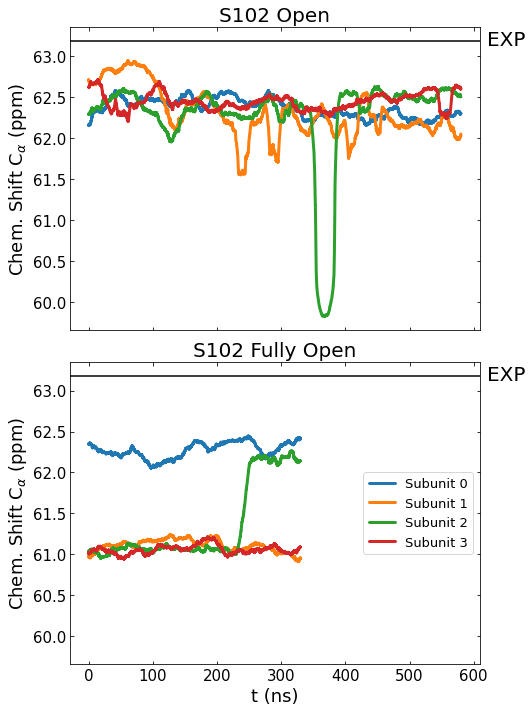

In [71]:
n_roll = 1000
resid = aa_selected[0]
dt= 0.02
fig, ax = plt.subplots(2, 1, figsize=(7.5, 10), sharex=True, sharey=True)
state = '3FB5_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
ax = ax.flatten()
for j, split in enumerate(np.split(df[resid], 4)):
    y = split.rolling(n_roll).median()[n_roll:]
    x = dt*np.arange(len(y))
    ax[0].plot(x,y, label=f'Subunit {j}', lw=3)
ax[0].axhline(y=df_exp_o[resid][0], c="black")
ax[0].text(650,63.2, 'EXP', fontsize=20, rotation=0, va='center', ha='center', c='black')
ax[0].set_title(f'{aa_dic[resid]}{resid} Open',fontsize=20)
ax[0].set_ylabel(r'Chem. Shift C$_\alpha$ (ppm)',fontsize=18)
ax[0].tick_params(labelsize=15)
state = '5VK6_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
ax = ax.flatten()
for j, split in enumerate(np.split(df[resid], 4)):
    y = split.rolling(n_roll).median()[n_roll:]
    x = dt*np.arange(len(y))
    ax[1].plot(x,y, label=f'Subunit {j}', lw=3)
ax[1].axhline(y=df_exp_o[resid][0], c="black")
ax[1].text(650,63.2, 'EXP', fontsize=20, rotation=0, va='center', ha='center', c='black')
ax[1].set_title(f'{aa_dic[resid]}{resid} Fully Open',fontsize=20)
ax[1].set_ylabel(r'Chem. Shift C$_\alpha$ (ppm)',fontsize=18)
ax[1].set_xlabel('t (ns)',fontsize=18)
ax[1].tick_params(labelsize=15)
ax[1].legend(loc='center right')


fig.tight_layout()
fig.savefig(reports_dir + f'for_print/time_series_{method}_{nucleus}_{resid}.png')
del df

## Study Inference

### Load Data 

In [80]:
model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"

In [81]:
my_model = az.from_netcdf(model_path)

In [95]:
my_model

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [82]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mean_o_c', 'mean_fo_c'], r'$\Delta$CS$_{sim}$', 'state',
    ['Open', 'Fully Open'])

### Statical filtering

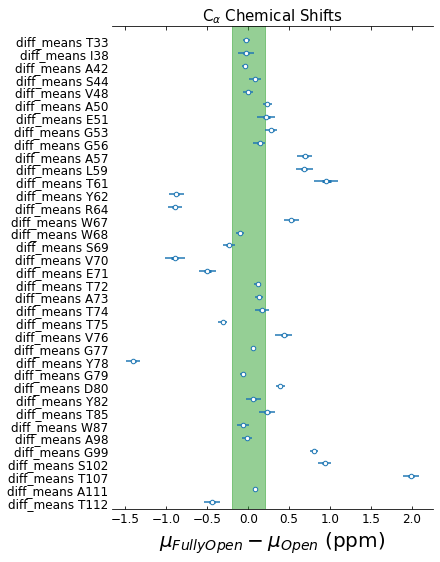

In [103]:
az.plot_forest(my_model.posterior, rope=(-0.2, 0.2), combined=True,
              var_names=['diff_means'])
plt.xlabel(r'$\mu_{Fully Open}-\mu_{Open}$ (ppm)', size=20)
plt.title(r'C$_\alpha$ Chemical Shifts', size=15)
plt.savefig(f'{reports_dir}for_print/diff_mu_{model_name}_{method}_{nucleus}.svg')

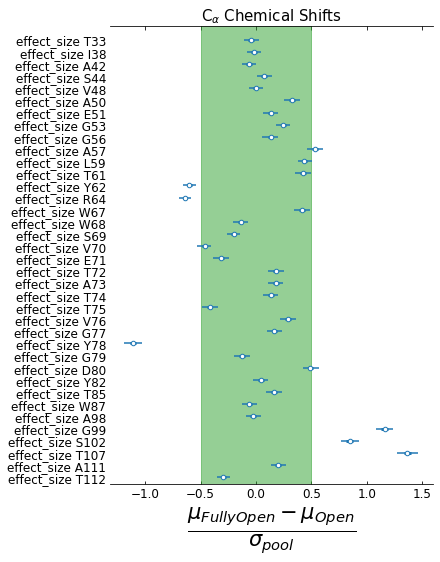

In [106]:
az.plot_forest(my_model, combined=True, var_names=['effect_size'], rope=(-0.5, 0.5))
plt.xlabel(r'$\frac{\mu_{Fully Open}-\mu_{Open}}{\sigma_{pool}}$',size=30)
plt.title(r'C$_\alpha$ Chemical Shifts', size=15)
plt.savefig(f'{reports_dir}for_print/effect_size_{model_name}_{method}_{nucleus}.svg')

### Markers

In [90]:
studied_res = ['Y62', 'R64', 'Y78', 'G99', 'S102', 'T107']

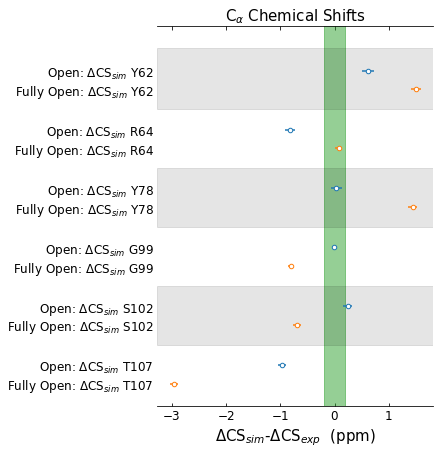

In [94]:
az.plot_forest(
    (my_model.posterior.sel(state="Open"), my_model.posterior.sel(state="Fully Open")),
    var_names="$\Delta$CS$_{sim}$",
    combined=True,
    colors=["C0", "C1"],
    model_names=["Open", "Fully Open"],
    rope=(-0.2, 0.2),
    coords={'resid': studied_res}
)
plt.xlabel(r'$\Delta$CS$_{sim}$-$\Delta$CS$_{exp}$  (ppm)',size=15)
plt.title(r'C$_\alpha$ Chemical Shifts', size=15)
#plt.xlim([-3,1])
plt.savefig(f'{reports_dir}for_print/assignment_{model_name}_{method}_{nucleus}_print.svg')